## Курсовой проект
#### По дисциплине "Методы, средства и технологии мультимедиа"
Выполнил Гаврилов М.С.  
Группа М8О-406Б-19

In [13]:
import pylab
import numpy as np
import copy

import sklearn as skl
from sklearn import datasets
from sklearn.pipeline import Pipeline
from nerus import load_nerus

import random

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from matplotlib import gridspec

### Датасет

In [14]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

### Постановка задачи 
Методами машинного обучения поздать модель, способную определять часть речи слова русского языка. Для обучения и тестирования используется датасет nerus, алгоритм - случайный лес.

### Анализ датасета и определение признаков
Датасет представляет из себя набор токенизированных предложений. Для решаемой задачи потребуется только слово (в виде текста) и его класс (часть речи). Извечем их.

Определим, какие классы присутствуют в датасете

In [15]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

PossibleClasses = []
selLen = 5000 #ограничитель, чтобы проходить не весь датасет, а только часть

for i in range (selLen):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
                         
            if(not token.pos in PossibleClasses):
                PossibleClasses.append(token.pos)

print(PossibleClasses)

['NOUN', 'ADP', 'ADJ', 'PROPN', 'VERB', 'PUNCT', 'DET', 'ADV', 'PRON', 'CCONJ', 'SCONJ', 'NUM', 'PART', 'AUX', 'X', 'SYM', 'INTJ']


In [16]:
Classes = PossibleClasses

Вероятно, не все классы подлежат помещению в выборку. Определим, что из себя представляют представлители классов.

['NOUN', 'ADP', 'ADJ', 'PROPN', 'VERB', 'PUNCT', 'DET', 'ADV', 'PRON', 'CCONJ', 'SCONJ', 'NUM', 'PART', 'AUX', 'X', 'SYM', 'INTJ']

In [17]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

selLen = 5000 #ограничитель, чтобы проходить не весь датасет, а только часть
ClCnt = np.zeros(len(Classes))
ClExmp = [[] for i in range(len(Classes))]


for i in range (selLen):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
                         
            if(ClCnt[PossibleClasses.index(token.pos)] < 5):
                ClCnt[PossibleClasses.index(token.pos)] += 1
                ClExmp[PossibleClasses.index(token.pos)].append(token.text)


In [18]:
for i in range(len(ClExmp)):
    print(PossibleClasses[i])
    for exmpl in ClExmp[i]:
        print("\t{}".format(exmpl))

NOUN
	Вице-премьер
	вопросам
	регионах
	смертность
	рака
ADP
	по
	в
	от
	По
	в
ADJ
	социальным
	высокая
	онкологические
	Псковской
	Тверской
PROPN
	Татьяна
	Голикова
	России
	РИА
	Новости
VERB
	рассказала
	зафиксирована
	сообщает
	становились
	напомнила
PUNCT
	,
	,
	.
	,
	,
DET
	каких
	Каких-либо
	Все
	Таким
	всем
ADV
	наиболее
	чаще
	также
	впервые
	ранее
PRON
	всего
	Это
	этом
	они
	их
CCONJ
	и
	а
	и
	а
	и
SCONJ
	что
	что
	чем
	Как
	как
NUM
	три
	289
	3,5
	меньше
	три
PART
	не
	не
	именно
	ли
	только
AUX
	будет
	были
	было
	была
	был
X
	#
	metoo
	#
	timesup
	marchforourlives
SYM
	+
	+
	&
	+
	№
INTJ
	Фу
	О
	О
	ура
	ура


Подсчитаем частотность классов в датасете

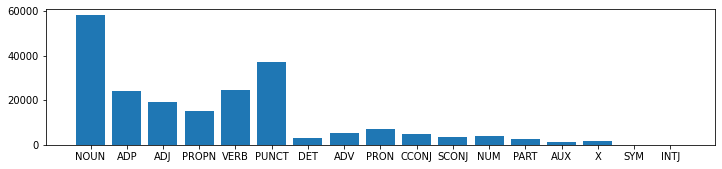

In [33]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClCnt = np.zeros(len(PossibleClasses))

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in PossibleClasses):
                clN = PossibleClasses.index(token.pos)
                ClCnt[clN] += 1

fig, ax = pylab.subplots()
fig.set_figwidth(12)
fig.set_figheight(2.5) 

ax.bar(PossibleClasses,ClCnt)
pylab.xticks(np.arange(len(PossibleClasses)))
pylab.show()

Определяем классы, которые можно использовать для решения задачи (все, кроме пунктуации, математических действий и 'X'), а также классы, от слов которых можно требовать уникальности (такие, к которым относятся 1000+ различных слов русского языка)

In [19]:
Classes   = ['NOUN', 'ADP', 'ADJ', 'PROPN', 'VERB', 'DET', 'ADV', 
             'PRON', 'CCONJ', 'SCONJ', 'NUM', 'PART', 'AUX']
ClassesUQ = ['NOUN', 'ADJ', 'PROPN', 'VERB', 'ADV', 'NUM'] 
            #исключаются те классы, для которых из 5000 предложений не найдено 500 уникальных примеров

Генерируем сбаллансированную выборку (так как в датасете столь много слов, что берется лишь часть)

Выборка с уникальными словами позволит исследовать справедливось предположения о деградации модели в словарь

In [20]:
def create_dataset(selLen = 5000,ClLen = 500,AllowedClasses = Classes,unique = False):
                   #сколько предложений просмотреть
                                 #сколько слов должно быть в каждом классе
                                            #какие части речи добавлять
                                                                      #требуется ли уникальность слов в датасете
        
    ClCnt = np.zeros(len(AllowedClasses))

    larrLB = [] #классы слов
    larrDC = [] #слова
    
    docs = load_nerus('nerus/nerus_lenta.conllu.gz') #заново загружаем датасет

    #Формирование обучающего датасета
    for i in range (selLen):
        doc = next(docs) #идем по предложениям
        
        for sent in doc.sents:
            for token in sent.tokens:
                if(token.pos in AllowedClasses):
                        clN = AllowedClasses.index(token.pos)

                        if(ClCnt[clN] < ClLen):
                            
                            if(unique and token.text in larrDC):
                                continue                                

                            ClCnt[clN] += 1

                            larrLB.append(AllowedClasses.index(token.pos))
                            larrDC.append(token.text)



    ClCnt = np.zeros(len(AllowedClasses))

    tarrLB = []
    tarrDC = []

    #формирование тестового датасета
    for i in range (selLen):
        doc = next(docs)
        
        for sent in doc.sents:
            for token in sent.tokens:
                if(token.pos in AllowedClasses):
                        clN = AllowedClasses.index(token.pos)

                        if(ClCnt[clN] < ClLen):
                            
                            if(unique and (token.text in tarrDC or token.text in larrDC)):
                                continue                    

                            ClCnt[clN] += 1

                            tarrLB.append(AllowedClasses.index(token.pos))
                            tarrDC.append(token.text)

    return np.array(larrLB),np.array(larrDC),np.array(tarrLB),np.array(tarrDC)

In [21]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(selLen = 10000)

with unique = false
words in train selection:
6500
unique words in train selection:
2191
count of words in dataset per class:


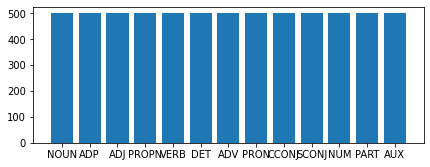

In [22]:
print("with unique = false")
print("words in train selection:")
print(len(larrDC))
print("unique words in train selection:")
print(len(np.unique(larrDC)))

print("count of words in dataset per class:")
fig, ax = pylab.subplots()
fig.set_figwidth(7)
fig.set_figheight(2.5) 

ax.bar(Classes,np.unique(larrLB,return_counts = True)[1])
pylab.xticks(np.arange(len(Classes)))
pylab.show()

In [23]:
larrLB,larrDC,tarrLB,tarrDC = create_dataset(AllowedClasses = ClassesUQ,unique = True)

with unique = false
words in train selection:
3000
unique words in train selection:
3000
count of words in dataset per class:


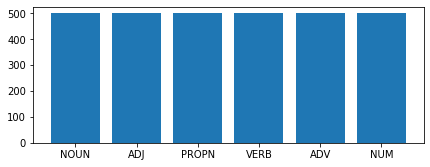

In [24]:
print("with unique = false")
print("words in train selection:")
print(len(larrDC))
print("unique words in train selection:")
print(len(np.unique(larrDC)))

print("count of words in dataset per class:")
fig, ax = pylab.subplots()
fig.set_figwidth(7)
fig.set_figheight(2.5) 

ax.bar(ClassesUQ,np.unique(larrLB,return_counts = True)[1])
pylab.xticks(np.arange(len(ClassesUQ)))
pylab.show()

## Определение оптимальных признаков.

Предполагаемые признаки:  
- первая буква слова
- последняя буква слова
- предпоследняя буква слова
- длина слова 

Убедимся, что слова разных классов различаются по этим признакам    
Также проверим вторую букву слова и третью с конца букву, возможно, они понадобятся для улучшения точности

In [35]:
alphabet = ['а', 'е', 'ё', 'и', 'о', 'у', 'ы', 'э', 'ю', 'я', 
            'б', 'в', 'г', 'д', 'ж', 'з', 'й', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т', 'ф', 'х', 'ц', 'ч', 'ш', 'щ',
            'ь', 'ъ']


FIRST letters by classes


NOUN


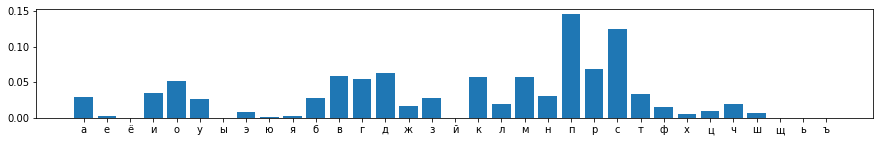

ADP


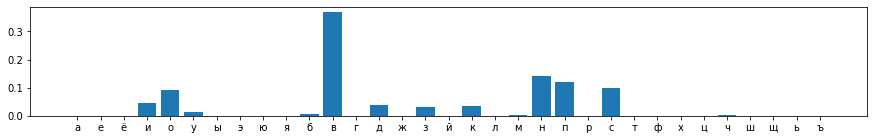

ADJ


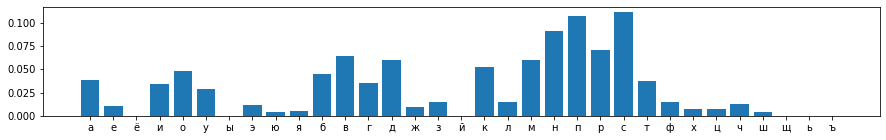

PROPN


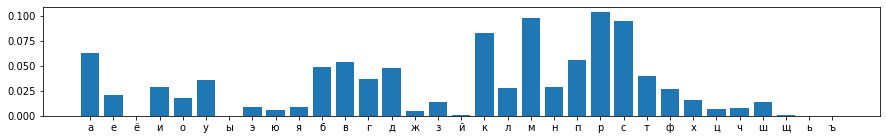

VERB


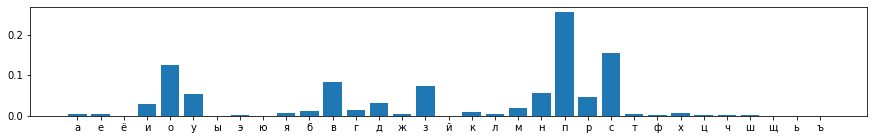

DET


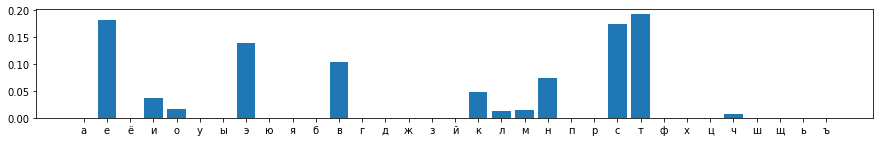

ADV


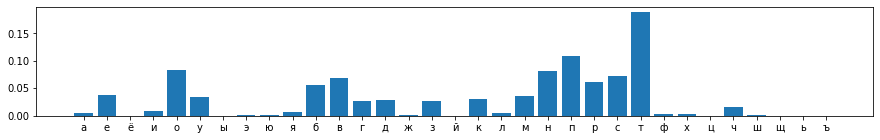

PRON


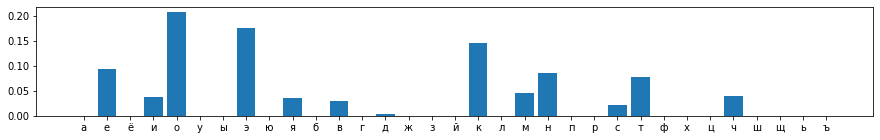

CCONJ


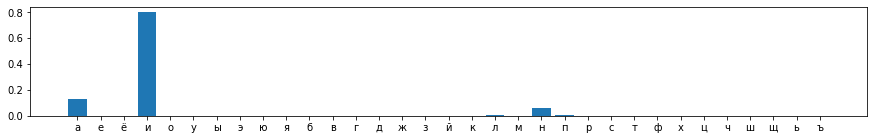

SCONJ


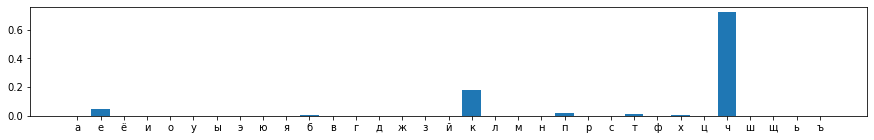

NUM


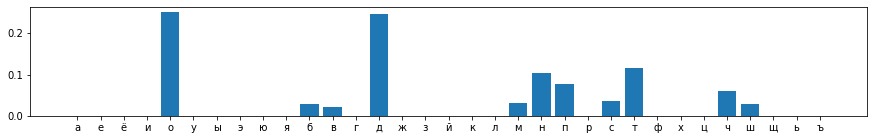

PART


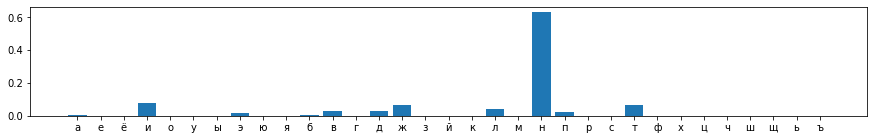

AUX


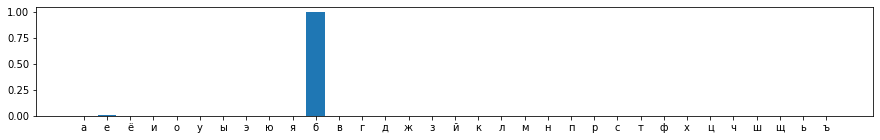

In [43]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqFST = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[0])
                except(ValueError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqFST[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqFST[i][j] /= ClCnt[i]


print("\nFIRST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqFST[i])
    pylab.xticks(np.arange(33))
    pylab.show()

Функция для вывода диаграмм для двух классов друг возле друга, чтобы их можно было легче сравнить:

In [56]:
def overlay(i,j, freq):
    try:
        s1 = int(i)
    except(BaseException):
        s1 = int(Classes.index(i))
    
    try:
        s2 = int(j)
    except(BaseException):
        s2 = int(Classes.index(j))
        
    
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(3) 
    
    a = np.arange(len(alphabet))
    
    ax.bar(a + 0.2,freq[s1],width = 0.4,label = Classes[s1])
    ax.bar(a - 0.2,freq[s2],width = 0.4,label = Classes[s2])
    
    ax.set_xticks(a)
    ax.set_xticklabels(alphabet)
    ax.legend()
    
    pylab.xticks(np.arange(33))
    pylab.show()

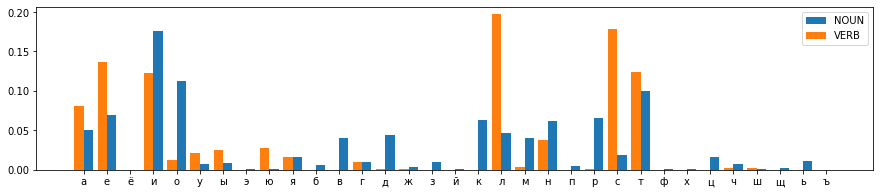

In [57]:
overlay("NOUN","VERB", ClassFreqFST)


LAST letters by classes


NOUN


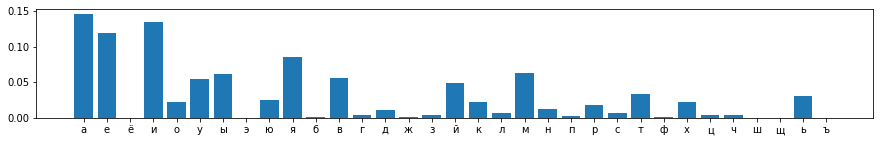

ADP


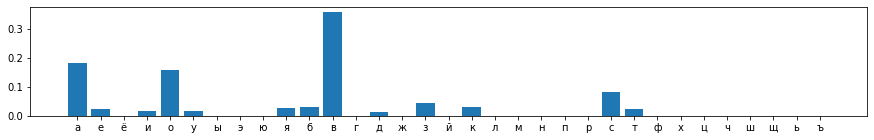

ADJ


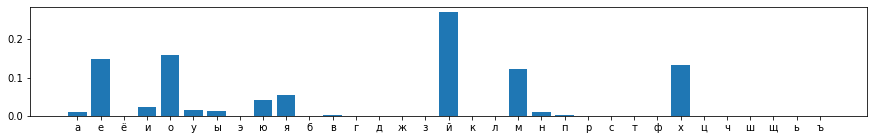

PROPN


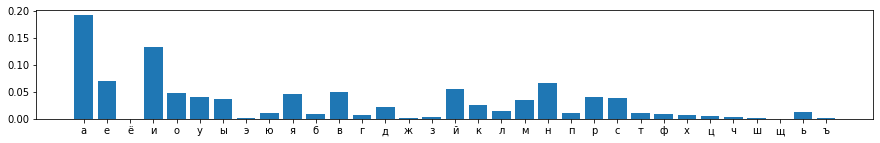

VERB


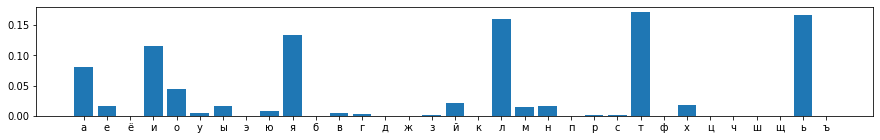

DET


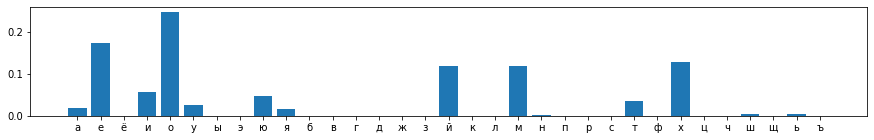

ADV


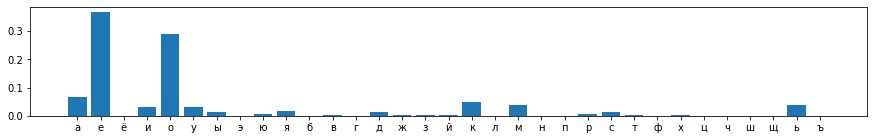

PRON


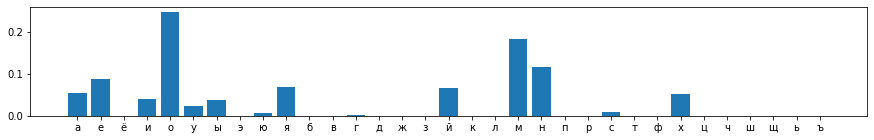

CCONJ


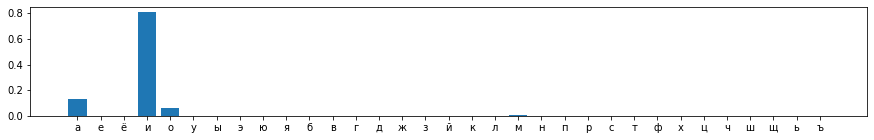

SCONJ


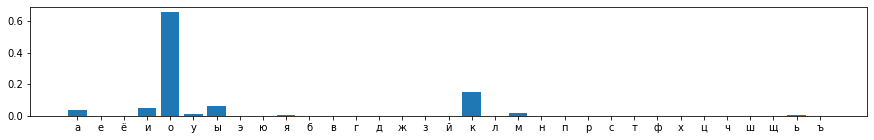

NUM


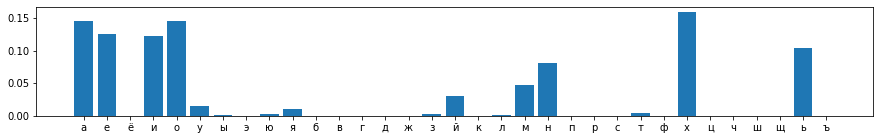

PART


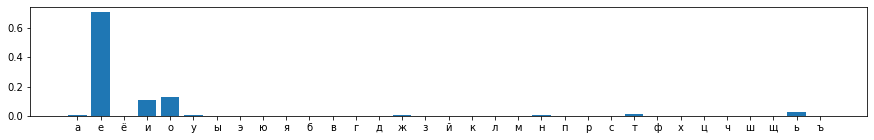

AUX


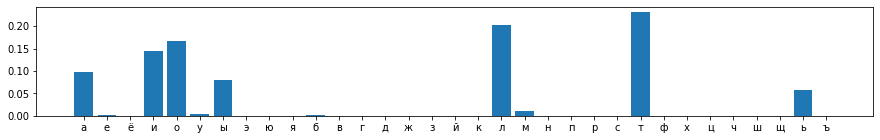

In [60]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqLST = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 1])
                except(ValueError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqLST[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqLST[i][j] /= ClCnt[i]


print("\nLAST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqLST[i])
    pylab.xticks(np.arange(33))
    pylab.show()

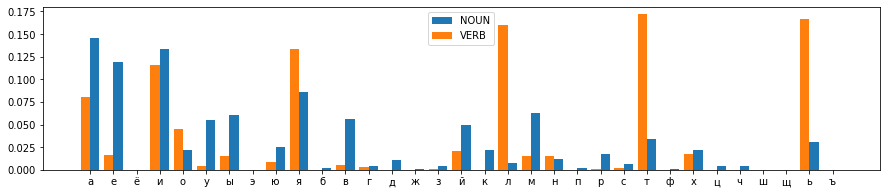

In [61]:
overlay("NOUN","VERB", ClassFreqSCD)


2-d LAST letters by classes


NOUN


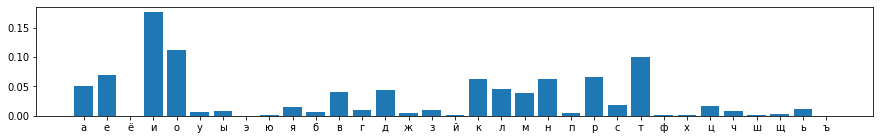

ADP


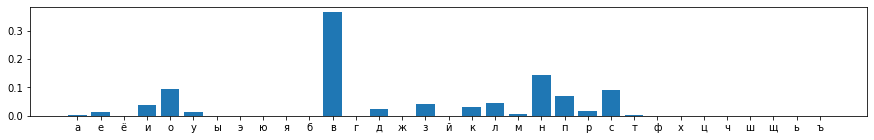

ADJ


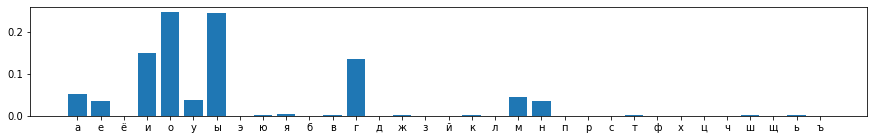

PROPN


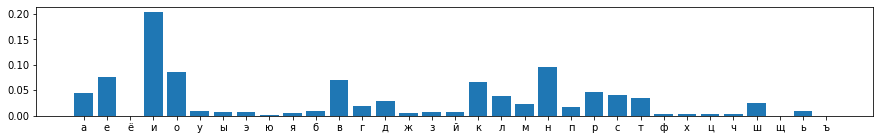

VERB


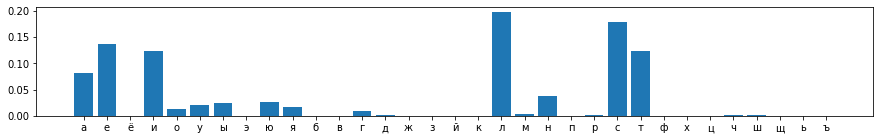

DET


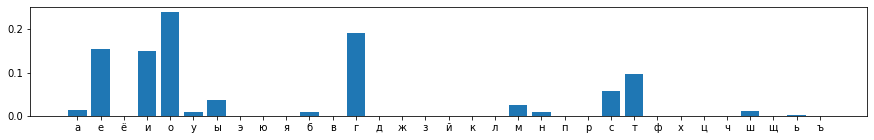

ADV


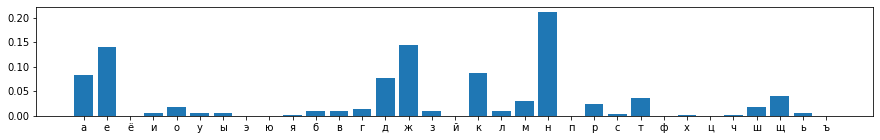

PRON


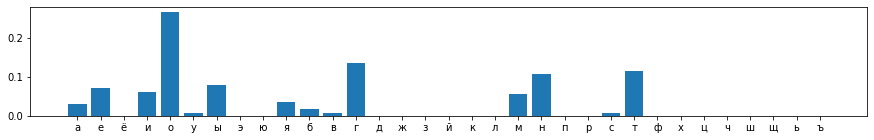

CCONJ


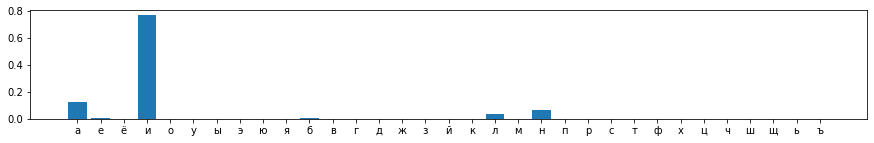

SCONJ


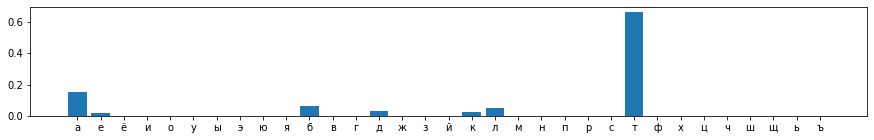

NUM


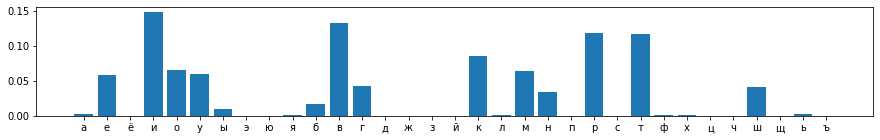

PART


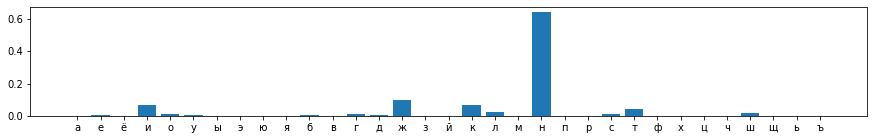

AUX


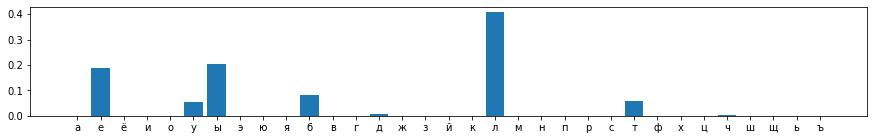

In [62]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqLST2 = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 2])
                except(ValueError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqLST2[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqLST2[i][j] /= ClCnt[i]


print("\n2-d LAST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqLST2[i])
    pylab.xticks(np.arange(33))
    pylab.show()

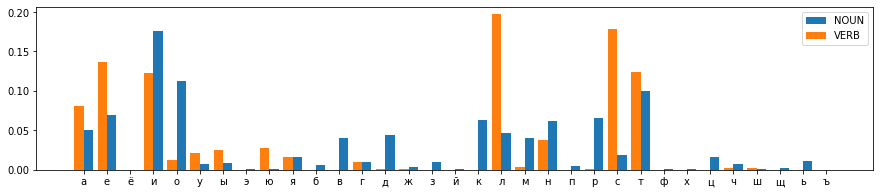

In [63]:
overlay("NOUN","VERB", ClassFreqLST2)

Третья с конца и вторая буквы


2-d FIRST letters by classes


NOUN


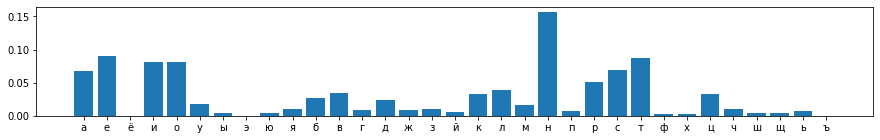

ADP


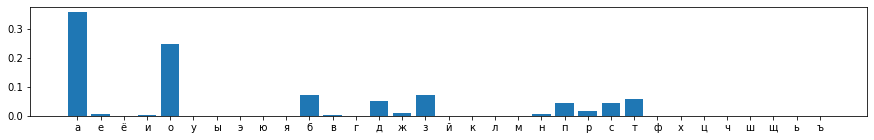

ADJ


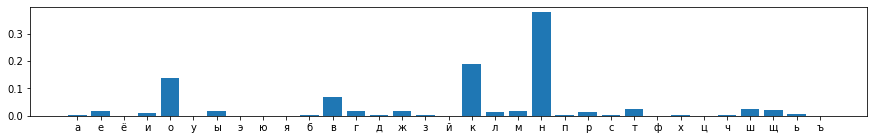

PROPN


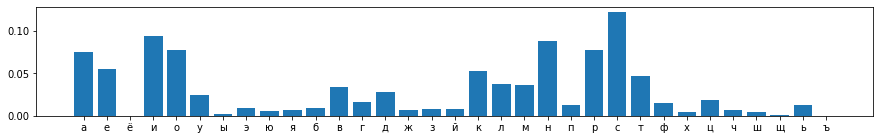

VERB


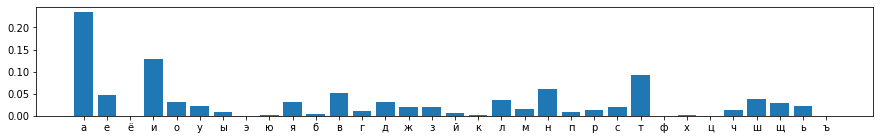

DET


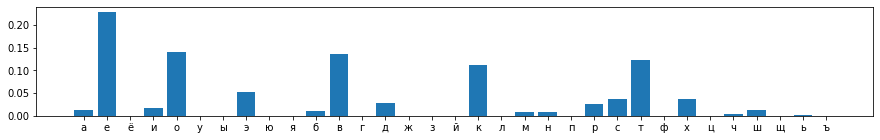

ADV


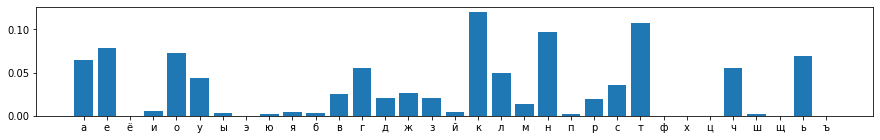

PRON


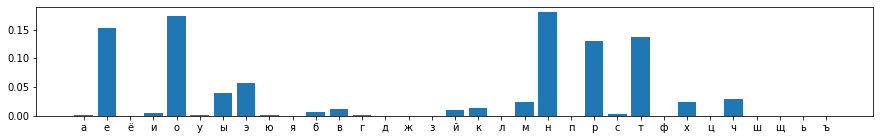

CCONJ


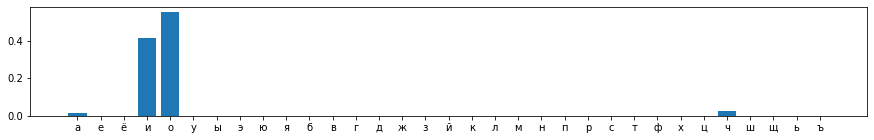

SCONJ


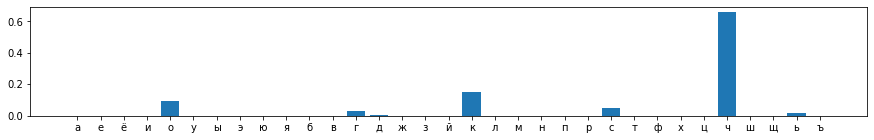

NUM


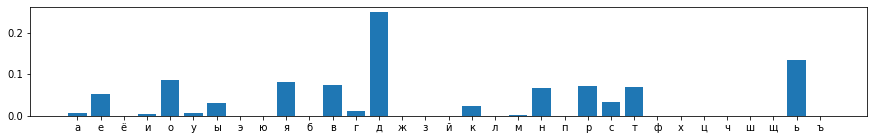

PART


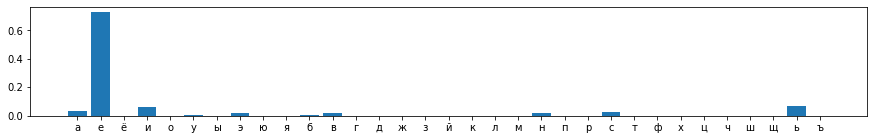

AUX


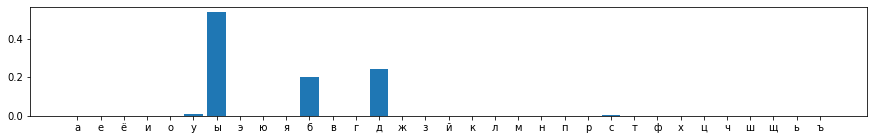

In [68]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqSCD = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 3])
                except(ValueError):
                    continue
                except(IndexError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqSCD[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqSCD[i][j] /= ClCnt[i]


print("\n2-d FIRST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqSCD[i])
    pylab.xticks(np.arange(33))
    pylab.show()

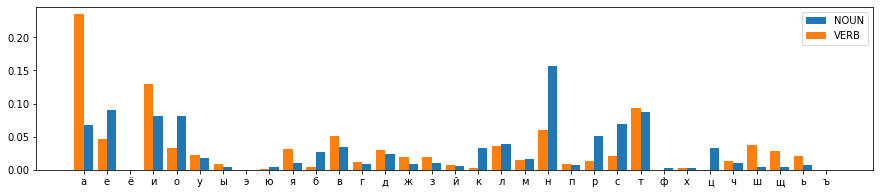

In [69]:
overlay("NOUN","VERB", ClassFreqSCD)


3-d LAST letters by classes


NOUN


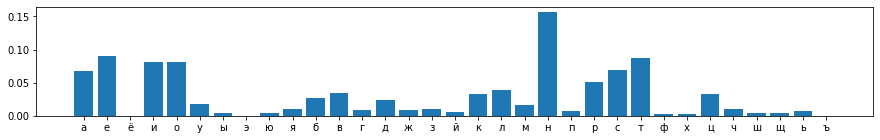

ADP


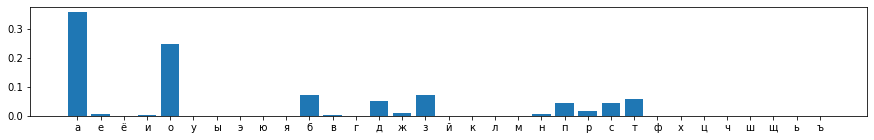

ADJ


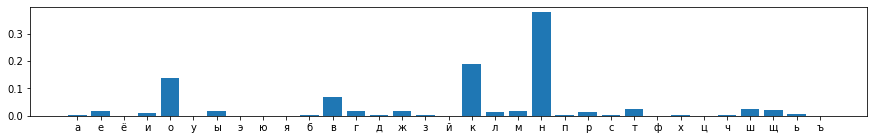

PROPN


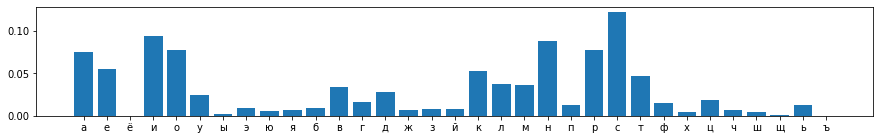

VERB


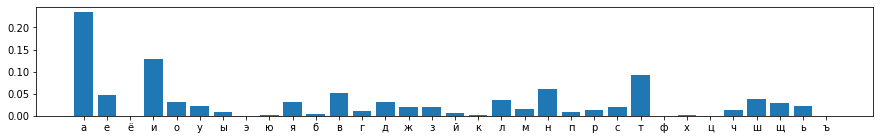

DET


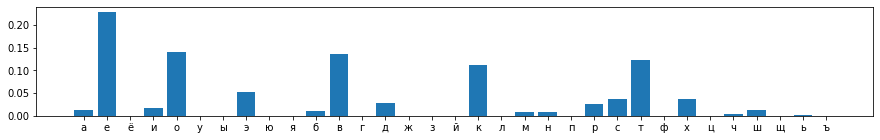

ADV


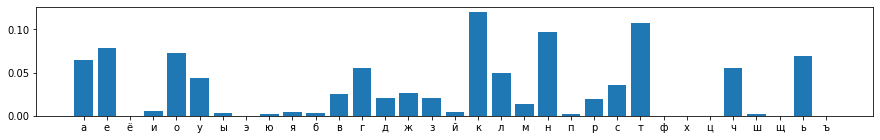

PRON


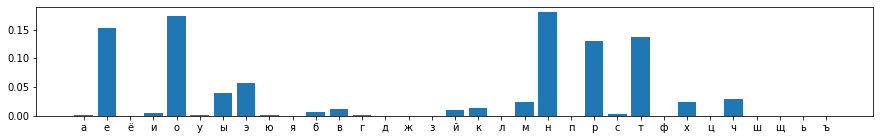

CCONJ


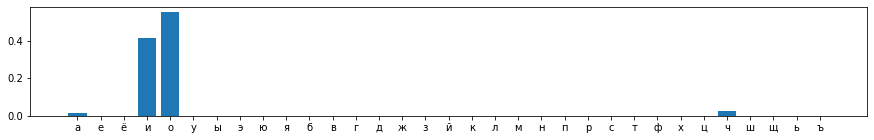

SCONJ


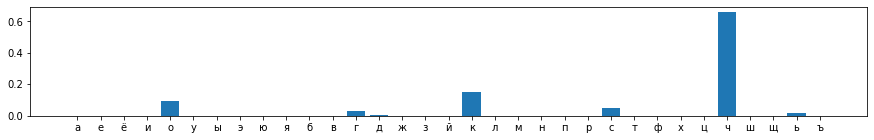

NUM


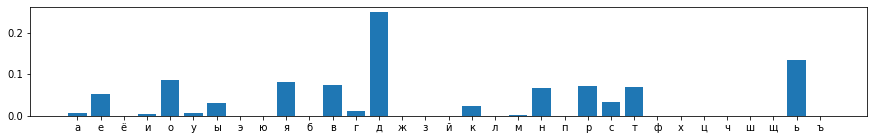

PART


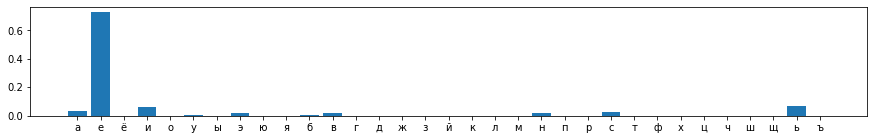

AUX


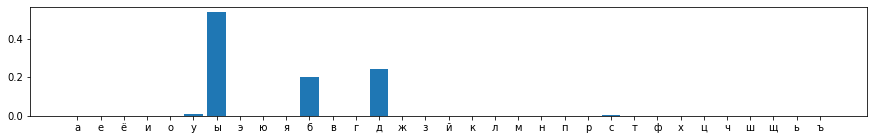

In [70]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClassFreqLST3 = np.zeros([len(Classes),len(alphabet)])
ClCnt = np.zeros(len(Classes)) #сколько слов каждого класса встретилось

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                
                try:
                    lp = alphabet.index(token.text.lower()[len(token.text) - 3])
                except(ValueError):
                    continue
                except(IndexError):
                    continue
                    
                clN = Classes.index(token.pos)
                                    
                ClassFreqLST3[clN][lp] += 1
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqLST3[i][j] /= ClCnt[i]


print("\n3-d LAST letters by classes\n\n")

for i in range(len(Classes)): 
    fig, ax = pylab.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print((Classes[i]))
    ax.bar(alphabet,ClassFreqLST3[i])
    pylab.xticks(np.arange(33))
    pylab.show()

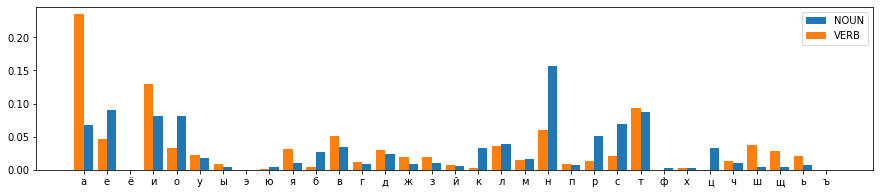

In [71]:
overlay("NOUN","VERB", ClassFreqLST3)

Длина слов по классам 


AVG length by classes


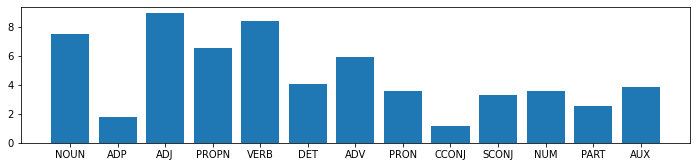

In [77]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

ClCnt = np.zeros(len(Classes))
CllenAvg = np.zeros(len(Classes))

for i in range (1000):
    doc = next(docs)
    
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos in Classes):
                clN = Classes.index(token.pos)
                CllenAvg[clN] += len(token.text)
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    CllenAvg[i] /= ClCnt[i]
             
print("\nAVG length by classes")
        
fig, ax = pylab.subplots()
fig.set_figwidth(12)
fig.set_figheight(2.5) 

ax.bar(Classes,CllenAvg)
pylab.xticks(np.arange(len(Classes)))
pylab.show()

Убедившись, что предлагаемыве признаки действительно отличаются у различных классов, приступим к построению модели

### Обработка данных
Мы не можем передавать на вход модели сами слова, необходимо выделить из них признаки.  
Для этого используем инструмент skl pipeline и skl Transformer.